In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

matplotlib.style.use('ggplot') 
pd.set_option('display.width', 200)

In [2]:
# Open StadtRad trips and preprocess
# - Format dates to datetime
with open('dataset/primaryData/stadtrad_trips.csv',  newline='\n') as trips_file, open('dataset/primaryData/stations.csv',  newline='\n') as stations_file:
    stadtrad_trips = pd.read_csv(trips_file, delimiter=',')
    start_stations = pd.read_csv(stations_file, delimiter=',')
    end_stations = start_stations.copy()
    stadtrad_trips = stadtrad_trips.merge(start_stations, left_on='start_station', right_on='number', suffixes=(None, '_start'))
    stadtrad_trips = stadtrad_trips.merge(end_stations, left_on='end_station', right_on='number', suffixes=(None, '_end'))
    stadtrad_trips['end_date'] = stadtrad_trips['end_date'].astype('datetime64[ns]')
    stadtrad_trips['start_date'] = stadtrad_trips['start_date'].astype('datetime64[ns]')

In [3]:
with open('dataset/primaryData/stadtrad_trips.csv',  newline='\n') as trips_file:
    bss_activity_trips_start = pd.read_csv(trips_file, delimiter=',')
    bss_activity_trips_end = bss_activity_trips_start.copy()
    df_bss_activity_trips_end = bss_activity_trips_end.drop(columns=['start_station', 'start_date'])
    df_bss_activity_trips_end['activity'] = 1
    df_bss_activity_trips_end.rename(columns={'end_date': 'timestamp', 'end_station': 'station'}, inplace=True)

    df_bss_activity_trips_end['timestamp'] = df_bss_activity_trips_end['timestamp'].astype('datetime64[ns]')
    all_bss_activity_trips = df_bss_activity_trips_end.groupby(['station', pd.Grouper(key='timestamp', freq="1h")]).sum().reset_index()

In [4]:
# Preprocess ZPID Covid-19 lockdown data

with open('dataset/primaryData/covid-19_lockdown.csv') as lockdown_file:
    lockdown = pd.read_csv(lockdown_file, delimiter=',')
    lockdown = lockdown.drop(columns=['stateID'])
    lockdown = lockdown.set_index(['state', 'Measure'])
    lockdown = lockdown.stack().reset_index().rename(columns={'level_2': 'date', 0: 'value'})
    lockdown['date'] = lockdown['date'].astype('datetime64[ns, utc]')
    lockdown['value'] = lockdown['value'].replace(' ',0).astype('int64')
    lockdown = lockdown.set_index('date')
    lockdown = lockdown[(lockdown['value'] > 0) & (lockdown.state == 'Hamburg')]
    lockdown = lockdown.drop(columns=['state'])
    lockdown = lockdown.groupby('Measure').resample('1h').ffill().rename(columns={'Measure': 'drop'}).reset_index().drop(columns=['drop']).set_index('date')

In [5]:
# Analyze Covid-19 lockdown data compared to normal BSS activity

activity_trips_copy = all_bss_activity_trips.copy().set_index('timestamp')
lockdown_copy = lockdown.copy().tz_localize(None)
activity_trips_lockdown = activity_trips_copy.groupby('timestamp').sum().drop(columns=['station'])
activity_trips_lockdown = activity_trips_lockdown.join(lockdown_copy, how='left')
social_distancing = activity_trips_lockdown[activity_trips_lockdown['Measure'] == 'dist']
social_distancing_start_comp = social_distancing.index.min() + pd.offsets.DateOffset(years=1)
social_distancing_end_comp = social_distancing.index.max() + pd.offsets.DateOffset(years=1)
comparison = activity_trips_lockdown[social_distancing_start_comp:social_distancing_end_comp]
print(social_distancing_start_comp, social_distancing_end_comp)
print(social_distancing['activity'].describe(), social_distancing['activity'].sum())
print(comparison['activity'].describe(), comparison['activity'].sum())

2022-01-01 00:00:00 2022-10-31 00:00:00
count    7270.000000
mean      231.755296
std       210.257322
min         1.000000
25%        54.000000
50%       178.000000
75%       349.000000
max      1096.000000
Name: activity, dtype: float64 1684861
count    7272.000000
mean      206.343784
std       164.431141
min         1.000000
25%        66.000000
50%       177.500000
75%       304.000000
max       873.000000
Name: activity, dtype: float64 1500532


In [6]:
# Merge BSS activity with meteorological data

weather_significant_factors = ['temp', 'pressure', 'wind_speed', 'humidity', 'rain_1h', 'snow_1h']

with open('dataset/primaryData/weather.csv') as weather_file:
        df_weather = pd.read_csv(weather_file)
        station_activity = all_bss_activity_trips.copy().set_index('timestamp')

        station_activity = station_activity.groupby('station')[['activity']].apply(lambda x: x.reindex(pd.date_range('2021-01-01', '2022-12-31', freq='1H')))

        station_activity = station_activity.fillna(0)
        station_activity = station_activity.reset_index().set_index('level_1')

        df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC', utc=True)
        weather = df_weather.set_index("dt_iso")
        weather.index = weather.index.tz_localize(None)
        station_demand_weather = station_activity.join(weather[weather_significant_factors])

        # ensure datatypes
        station_demand_weather['temp'] = (station_demand_weather['temp'].astype('float64') - 273.15).fillna(0)
        station_demand_weather['pressure'] = station_demand_weather['pressure'].fillna(0)
        station_demand_weather['weekday'] = station_demand_weather.index.dayofweek
        station_demand_weather['hour'] = station_demand_weather.index.hour
        station_demand_weather['rain_1h'] = station_demand_weather['rain_1h'].fillna(0)
        station_demand_weather['snow_1h'] = station_demand_weather['snow_1h'].fillna(0)
        station_demand_weather["is_weekend"] = (station_demand_weather.index.dayofweek >= 5).astype(int)
        station_demand_weather["station"] = station_demand_weather["station"].astype(int)

/var/folders/p4/f1wvg58s525fjnmcn8pzkpdc0000gn/T/ipykernel_62703/635266767.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = station_demand_weather_copy.corr()


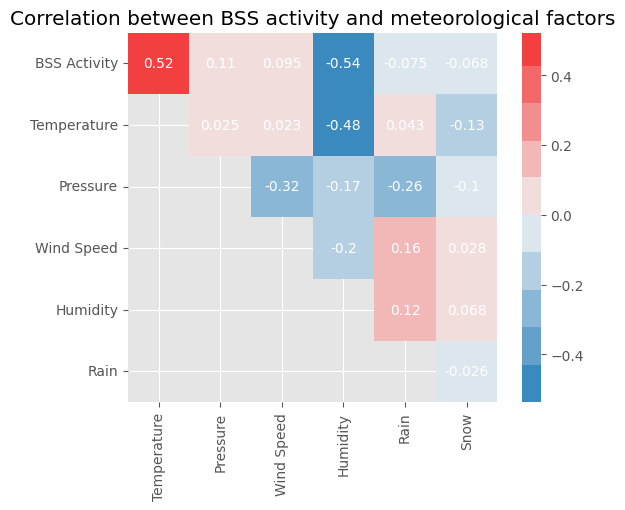

In [7]:
# Correlation between BSS activity and meteorological factors

station_demand_weather_copy = station_demand_weather.copy()
station_demand_weather_copy = station_demand_weather_copy.groupby(pd.Grouper(freq='1h')).agg(
    {
        'activity': 'mean',
        'temp': 'mean',
        'pressure': 'mean',
        'wind_speed': 'mean',
        'humidity': 'mean',
        'rain_1h': 'mean',
        'snow_1h': 'mean',
    }
).reset_index().rename(columns={'activity': 'BSS Activity', 'temp': 'Temperature', 'pressure': 'Pressure', 'wind_speed': 'Wind Speed', 'humidity': 'Humidity', 'rain_1h': 'Rain', 'snow_1h': 'Snow'})

corr_matrix = station_demand_weather_copy.corr()
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(240, 12, 84, 55, 1, 10)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=0, annot=True, annot_kws={ 'color':'white', 'verticalalignment': 'center',})
ax.set_title('Correlation between BSS activity and meteorological factors')
ax.set_xlim(1, 7)
ax.set_ylim(6, 0)
  
plt.show()

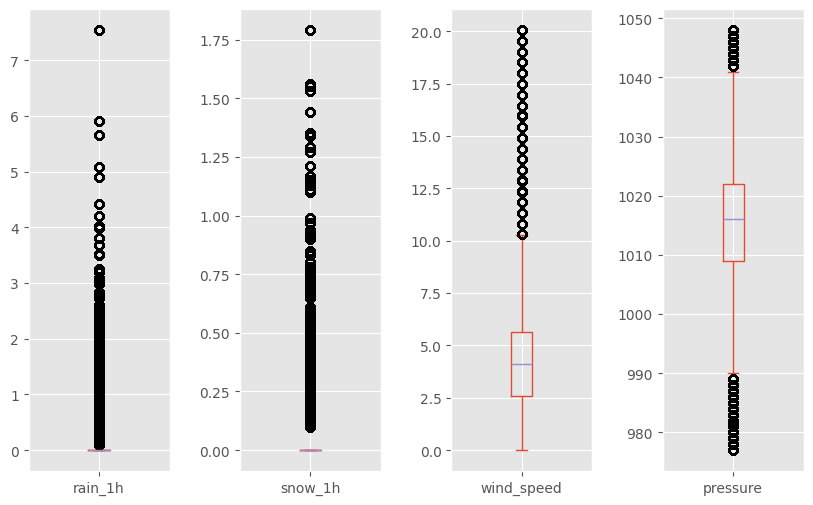

In [8]:
# Sanity Check meteorological data due to unexpected absences of effects

station_demand_weather[['rain_1h', 'snow_1h', 'wind_speed', 'pressure']].plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(10, 6)
)

# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [9]:
# Preprocess public hours from scraped foursquare data

import re
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

with open('dataset/primaryData/public_hours.csv') as social_interest_file:
    social_interest = pd.read_csv(social_interest_file)
    df = []  
    weekday_intervals = {}
    for weekday in weekdays:
        weekday_intervals[weekday] = pd.date_range(start='2021-1-1', end='2021-12-31', freq=f"W-{weekday[:3].upper()}", tz="UTC")

    pattern = r"(.{2}):"
    for _, row in social_interest.iterrows():
        public_hours_interval = pd.DatetimeIndex([], tz='UTC')
        for weekday in weekdays:
            if row[weekday] is np.nan:
                continue
            match = re.findall(pattern, row[weekday])
            start_time = int(match[0])
            end_time = int(match[1])

            for date_day in weekday_intervals[weekday]:
                public_hours_interval = public_hours_interval.union(
                    pd.date_range(start=date_day.replace(hour=start_time), end=date_day.replace(hour=end_time), freq='H', tz='UTC')
                )
        df.append({
            'station': row['Number_Station'],
            'public_hours': public_hours_interval,
            'public_hours_location': row['Name']
        })

    public_hours = pd.DataFrame(df)
    public_hours = public_hours.explode('public_hours')

In [10]:
# Merge BSS activity, meteorological and public hours data

public_hours_copy = public_hours.copy()
public_hours_copy['public_hours'] = public_hours_copy['public_hours'].dt.tz_convert(None)

station_demand_weather_public_hours = station_demand_weather.copy()
station_demand_weather_public_hours = station_demand_weather_public_hours.reset_index()

# merge station_demand_weather_public_hours with public_hours on station and index and station and public_hours
station_demand_weather_public_hours = pd.merge(
    station_demand_weather_public_hours, public_hours_copy[['public_hours', 'station', 'public_hours_location']], 
    how='left', left_on=['station', 'index'], right_on=['station', 'public_hours']
)
station_demand_weather_public_hours['public_hours'] = pd.to_datetime(station_demand_weather_public_hours['public_hours'])
station_demand_weather_public_hours['is_public_hours'] = station_demand_weather_public_hours['public_hours'].apply(lambda x: 0 if pd.isnull(x) else 1)
station_demand_weather_public_hours = station_demand_weather_public_hours.drop(columns=['public_hours'])
station_demand_weather_public_hours.index = station_demand_weather_public_hours['index'].astype('datetime64[ns]')
station_demand_weather_public_hours['is_weekend'] = (station_demand_weather_public_hours.index.dayofweek >= 5).astype(str)
station_demand_weather_public_hours['weekday'] = station_demand_weather_public_hours.index.dayofweek.astype(str)
station_demand_weather_public_hours['time_of_day'] = station_demand_weather_public_hours.index.hour
station_demand_weather_public_hours["month"] = station_demand_weather_public_hours.index.month.astype(str)
station_demand_weather_public_hours["log_activity"] = np.log(station_demand_weather_public_hours['activity'] + 1e-8)
station_demand_weather_public_hours["avg_activity_by_station"] = station_demand_weather_public_hours.groupby('station')['activity'].transform('mean')
station_demand_weather_public_hours = station_demand_weather_public_hours.groupby(['station',pd.Grouper(freq='4h', key='index')]).agg({
    'is_public_hours': 'mean',
    'activity': 'sum',
    'temp': 'mean',
    'humidity': 'mean',
    'weekday': 'first',
    'is_weekend': 'first',
    'time_of_day': 'first',
    'avg_activity_by_station': 'mean',
    'month': 'first',
    'log_activity': 'mean',
    'activity': 'mean'
}).reset_index()
station_demand_weather_public_hours['time_idx'] = station_demand_weather_public_hours.groupby('station').cumcount()
station_demand_weather_public_hours = station_demand_weather_public_hours.rename(columns={'index': 'timestamp'})

/var/folders/p4/f1wvg58s525fjnmcn8pzkpdc0000gn/T/ipykernel_62703/1358268038.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stations = stations.groupby([stations.date.dt.hour, 'name'])['demand', 'supply', 'diff'].mean().reset_index().rename(columns={'date': 'hour'}).rename(columns={'demand': 'Demand', 'supply': 'Supply', 'diff': 'Relative Difference'})


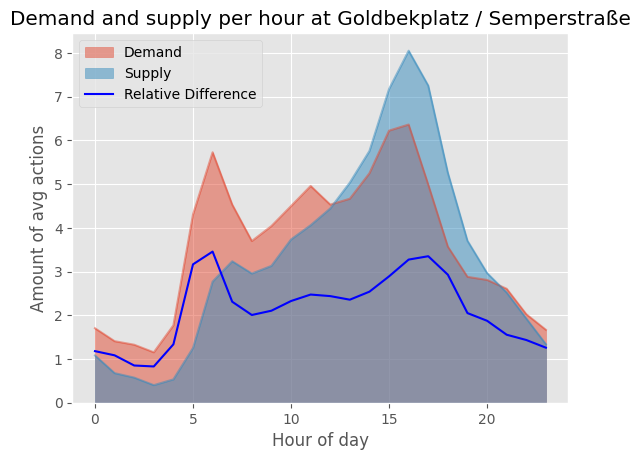

In [11]:
# Analyze BSS balance per hour at station with highest imbalance 

stadtrad_trips_copy = stadtrad_trips.copy()

station_demand_per_day = stadtrad_trips_copy.groupby(['start_station', 'name', pd.Grouper(key='start_date', freq='1h')])['start_date'].count().rename('demand').reset_index()
station_supply_per_day = stadtrad_trips_copy.groupby(['end_station', 'name_end', pd.Grouper(key='end_date', freq='1h')])['end_date'].count().rename('supply').reset_index()
station_demand_per_day = station_demand_per_day.rename(columns={'start_station': 'station', 'start_date': 'date'})
station_supply_per_day = station_supply_per_day.rename(columns={'end_station': 'station', 'name_end': 'name', 'end_date': 'date'})

stations = pd.merge(station_demand_per_day, station_supply_per_day,  how='left', left_on=['station','date', 'name'], right_on = ['station','date', 'name'])
stations = stations.fillna(0)
stations['diff'] = abs(stations['demand'] - stations['supply'])

# get stations with highest imbalance (Goldbekplatz / Semperstraße)
max_stations = stations.groupby('station')['diff'].sum().nlargest(1).reset_index()
stations = stations[stations.station.isin(max_stations.station)]

stations = stations.groupby([stations.date.dt.hour, 'name'])['demand', 'supply', 'diff'].mean().reset_index().rename(columns={'date': 'hour'}).rename(columns={'demand': 'Demand', 'supply': 'Supply', 'diff': 'Relative Difference'})

stations = stations.set_index('hour')

ax = stations[['Demand', 'Supply']].plot.area(stacked=False)   
ax = stations[['Relative Difference']].plot.line(
    ax=ax, color='b', title='Demand and supply per hour at Goldbekplatz / Semperstraße', xlabel='Hour of day', ylabel='Amount of avg actions')

/var/folders/p4/f1wvg58s525fjnmcn8pzkpdc0000gn/T/ipykernel_62703/3173928979.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  station_demand_weather_public_hours_copy = station_demand_weather_public_hours_copy.set_index('timestamp').groupby(pd.Grouper(freq='1d')).sum()


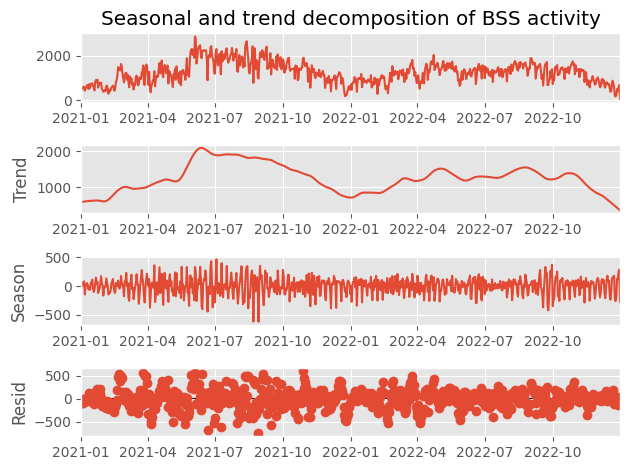

In [12]:
# Decompose seasonal and trend components of BSS activity

from statsmodels.tsa.seasonal import STL

station_demand_weather_public_hours_copy = station_demand_weather_public_hours.copy()
station_demand_weather_public_hours_copy = station_demand_weather_public_hours_copy.set_index('timestamp').groupby(pd.Grouper(freq='1d')).sum()
results = STL(station_demand_weather_public_hours_copy['activity'].rename('Seasonal and trend decomposition of BSS activity'), seasonal=5, trend=47).fit()
fig = results.plot()

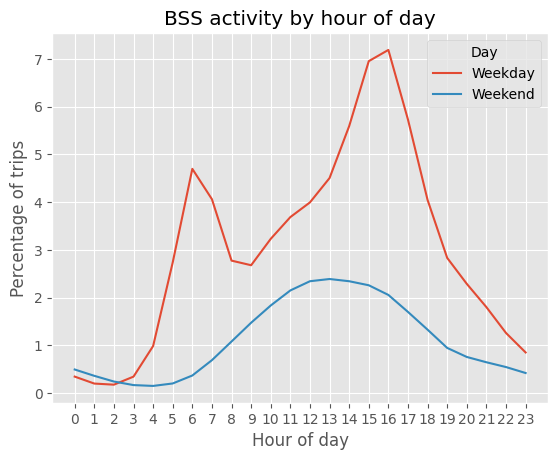

In [13]:
# Analyze BSS activity by hour of day

trips = stadtrad_trips.copy()

# group by hour of day also weekday and weekend
trips['Day'] = np.where(trips['start_date'].dt.dayofweek < 5, 'Weekday', 'Weekend')
start_hour = trips.groupby([trips.Day, trips.start_date.dt.hour]).size().reset_index()

# percentage of trips
start_hour[0] = start_hour[0] / start_hour[0].sum() * 100
start_hour = start_hour.pivot(index='start_date', columns='Day', values=0)

start_hour.plot(xlabel='Hour of day', ylabel='Percentage of trips', title='BSS activity by hour of day').set_xticks(start_hour.index)

In [14]:
with open('dataset/primaryData/stations.csv') as stations_file:
    stations = pd.read_csv(stations_file, delimiter=',')
    stadtrad_trips_copy = stadtrad_trips.copy()
    stadtrad_trips_station = pd.merge(left=stadtrad_trips_copy, right=stations, left_on="start_station", right_on='number', suffixes=('_start', None))
    stadtrad_trips_station = pd.merge(left=stadtrad_trips_station, right=stations, left_on="end_station", right_on='number', suffixes=(None, '_end'))
    stadtrad_trips_station = stadtrad_trips_station.loc[:,~stadtrad_trips_station.columns.duplicated()]

    station_demand_per_day = stadtrad_trips_station.groupby(['start_station', 'latitude_start', 'longitude_start', 'name_start', pd.Grouper(key='start_date', freq='1h')])['start_date'].count().rename('demand').reset_index()
    station_supply_per_day = stadtrad_trips_station.groupby(['end_station', 'latitude_end', 'longitude_end', 'name_end', pd.Grouper(key='end_date', freq='1h')])['end_date'].count().rename('supply').reset_index()
    
    station_demand_per_day = station_demand_per_day.rename(columns={'latitude_start': 'latitude', 'longitude_start': 'longitude', 'start_date': 'date', 'name_start': 'name'})
    station_supply_per_day = station_supply_per_day.rename(columns={'latitude_end': 'latitude', 'longitude_end': 'longitude', 'name_end': 'name', 'end_date': 'date'})

    stadtrad_trips_unidirectional = pd.merge(station_demand_per_day, station_supply_per_day,  how='outer', left_on=['date', 'name', 'latitude', 'longitude'], right_on = ['date', 'name', 'latitude', 'longitude'])
    stadtrad_trips_unidirectional['date'] = stadtrad_trips_unidirectional['date'].astype('datetime64[ns]')    
    stadtrad_trips_unidirectional = stadtrad_trips_unidirectional.fillna(0)

    # group by name and calculate new column with difference between demand and supply
    stadtrad_trips_unidirectional['diff'] = stadtrad_trips_unidirectional['supply'] - stadtrad_trips_unidirectional['demand']

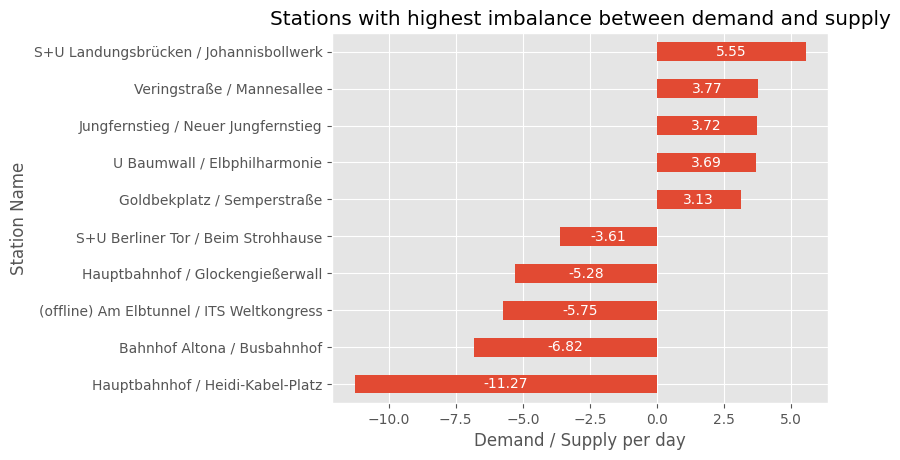

In [15]:
stadtrad_trips_unidirectional_copy = stadtrad_trips_unidirectional.copy()
station_demand_per_day = stadtrad_trips_unidirectional_copy.groupby(['name', pd.Grouper(freq='D', key='date')])['diff'].sum().reset_index()
station_demand_mean = station_demand_per_day.groupby('name')['diff'].mean()
too_high_demand = station_demand_mean.nsmallest(5)
too_high_availability = station_demand_mean.nlargest(5)

bad_stations = pd.concat([too_high_availability, too_high_demand])
bad_stations = round(bad_stations, 2)

ax = bad_stations.sort_values().plot.barh(legend=False, xlabel='Demand / Supply per day', ylabel='Station Name', title='Stations with highest imbalance between demand and supply')

for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white')

In [16]:
import plotly.graph_objs as go

stadtrad_trips_unidirectional_copy = stadtrad_trips_unidirectional.copy()
stadtrad_trips_unidirectional_copy['count'] = stadtrad_trips_unidirectional_copy['demand'] + stadtrad_trips_unidirectional_copy['supply']
max_stations = stadtrad_trips_unidirectional_copy.groupby(['name', 'latitude', 'longitude']).agg({ 'diff': 'sum', 'count': 'sum' }).reset_index()
max_stations['size'] = max_stations['count'].abs() * 0.001

data = []
dots = {}
dots["lat"] = []
dots["lon"] = []
dots["name"] = []
dots["size"] = []
dots["diff"] = []
for index, row in max_stations.iterrows():
    dots["lat"].append(row["latitude"])
    dots["lon"].append(row["longitude"])
    dots["name"].append(row["name"])
    dots["size"].append(row["size"])
    dots["diff"].append(row["diff"])

data.append(go.Scattermapbox(
    name="StadtRad-Stationen",
    lat=dots["lat"],
    lon=dots["lon"],
    mode='markers',
    marker=go.scattermapbox.Marker(
        cmid=0,
        colorscale='balance_r',
        allowoverlap=True,
        size=dots["size"],
        color=dots['diff'],
        showscale=True,
    ),
    hoverinfo="text",
    showlegend=False,
    text=dots["name"],
))


# Define the layout of the map
layout = go.Layout(
    margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    ),
    autosize=True,
    mapbox = go.layout.Mapbox(
    accesstoken = 'pk.eyJ1Ijoic2ViYXN0aWFucnVlaG1hbm4iLCJhIjoiY2xndXZucG40MTl3bTNzcXY0NWV0MmM5cCJ9.KjxLhiayvCpxzl_aCvOzpQ',
        center = go.layout.mapbox.Center(
            lon = 9.993682,
            lat = 53.551086
        ),
        style='streets',
        zoom = 11
    ),
)

# Create the figure and add the traces
fig = go.Figure(data=data, layout=layout)

fig.show()